In [1]:
%matplotlib inline
import numpy as np
import subprocess
import matplotlib.pyplot as plt

In [2]:
def get_SNR(file):
    with open(file, "rt")as f:
        a = f.readlines()
    lst = []
    for x in a:
        if "Value:" in x:
            lst.append(float(x.split("Value: ")[1]))
        #print(x.split("bla"))
    lst = lst[len(lst)//2 : ]
    return (np.array(lst).mean(), np.array(lst).std())

In [3]:
def step1(file):
    with open("output.data", "rb") as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    match = np.array([0, 0, 178, 62, 71, 168, 187, 253, 16, 38, 149, 55, 226, 170, 26], dtype = np.uint8)
    match_extended = np.tile(match, int(rcv.shape[0]/len(match)))

    idx = np.argmax([np.mean(np.equal(np.packbits(np.roll(np.unpackbits(rcv), i)), match_extended)) for i in range(15 * 8)])

    to_write = np.packbits(np.roll(np.unpackbits(rcv), idx))
    
    
    new_arr = []
    tx_inverted = np.invert(match)
    rcv_splitted = np.split(to_write, len(rcv)/len(match))
    
    
    for x in rcv_splitted:
        comp1 = np.mean(np.equal(np.unpackbits(match), np.unpackbits(x)))
        comp2 = np.mean(np.equal(np.unpackbits(tx_inverted), np.unpackbits(x)))
        if comp2 > comp1:
            new_arr.append(np.invert(x))
        else:
            new_arr.append(x)
            
    final = np.array(new_arr, dtype = np.uint8).ravel()
    
    
    with open("output2.data", "wb")as f:
        f.write(final)

In [4]:
def step2():
    process=subprocess.Popen(["python2", "BCH_Recoder.py"],
                             stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE,
                             stderr=subprocess.PIPE)


    #time.sleep(10)

    # while os.stat("output.data").st_size < os.stat("orig_pinguim.bmp").st_size * 2:
    #     pass

    inputdata= b" "
    stdoutdata,stderrdata=process.communicate(input=inputdata)
    
    return

In [5]:
def step3(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    final = np.frombuffer(_, dtype = np.uint8)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    match_extended_final = np.tile(tx, int(final.shape[0]/len(tx)))
    
    return (1 - np.mean(np.equal(np.unpackbits(final), np.unpackbits(match_extended_final))))

In [20]:
%%time
step1("output.data")

CPU times: user 7.55 s, sys: 1.9 s, total: 9.45 s
Wall time: 9.46 s


In [21]:
%%time
step2()

CPU times: user 3.93 ms, sys: 3.99 ms, total: 7.92 ms
Wall time: 15.6 s


In [22]:
%%time
step3("output3.data")

CPU times: user 24.5 ms, sys: 8.12 ms, total: 32.6 ms
Wall time: 33.2 ms


0.007154107142857136

In [23]:
get_SNR("output.txt"), step3("output3.data")

((2.1156330970149257, 0.47410498306463156), 0.007154107142857136)

## <font color = red> Quanto mais baixo o SNR, maior a chance de ocorrer problemas na recepção, mais chance do resultado obtido ser ruim
    
# <font color = blue> Resultados obtidos simulados
  <font color = blue> SNR Média, SNR STD, BER

   

In [24]:
a = """
((4.962410597014925, 0.3229306215766513), 4.482142857142879e-05)

((3.472397835820895, 0.3841866635229526), 0.0009147321428570887)

((2.1156330970149257, 0.47410498306463156), 0.007154107142857136)
"""

In [25]:
snr_avgs = []
snr_stds = []
bers = []

for line in a.splitlines():
    aux = line.replace("(", "").replace(")", "").split(",")
    if aux != [""]:
        snr_avgs.append(float(aux[0]))
        snr_stds.append(float(aux[1]))
        bers.append(float(aux[2]))

In [26]:
import math

In [27]:
10*math.log10(15/7)

3.3099321904142442

In [28]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)

In [29]:
simu = np.load("simu_coded_bpsk.npy")

In [30]:
simu

array([1.95756562e-01, 1.40599396e-01, 8.95375978e-02, 4.88179988e-02,
       2.18793995e-02, 7.66173316e-03, 2.00903328e-03, 3.48333324e-04,
       3.85999988e-05, 2.49999991e-06, 0.00000000e+00])

In [31]:
np.array(snr_avgs) + 10*math.log10(15/7)

array([8.27234279, 6.78233003, 5.42556529])

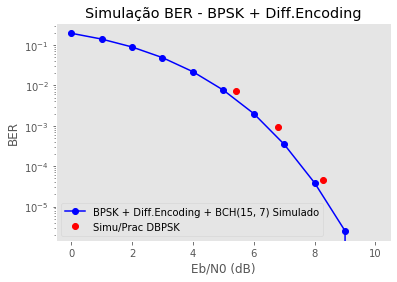

In [33]:
plt.style.use('ggplot')
#plt.semilogy(EbN0_range, theory, "g-.", label = "BPSK + Diff.Encoding Teórico")
plt.semilogy(EbN0_range, simu, "b-o", label = "BPSK + Diff.Encoding + BCH(15, 7) Simulado")
plt.semilogy(np.array(snr_avgs) + 10 * math.log10(15/7), bers, "o", color = "red", label = "Simu/Prac DBPSK")
plt.legend()
plt.grid()

plt.title('Simulação BER - BPSK + Diff.Encoding')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.savefig("Curva.png")